In [2]:
high_conf_pearson = {
    "gpt-4o": 0.75,
    "gpt-5": 0.45,
    "gpt-5-mini": 0.42,
    "qwen3-30B-Thinking": 0.37,
    "deepseek-R1-distill-qwen-32B": 0.48,
    "ChemDFM-R-14B": -0.03
}

full_pearson = {
    "gpt-4o": 0.61,
    "gpt-5": 0.68,
    "gpt-5-mini": 0.33,
    "qwen3-30B-Thinking": 0.36,
    "deepseek-R1-distill-qwen-32B": 0.24,
    "ChemDFM-R-14B": 0.26
}

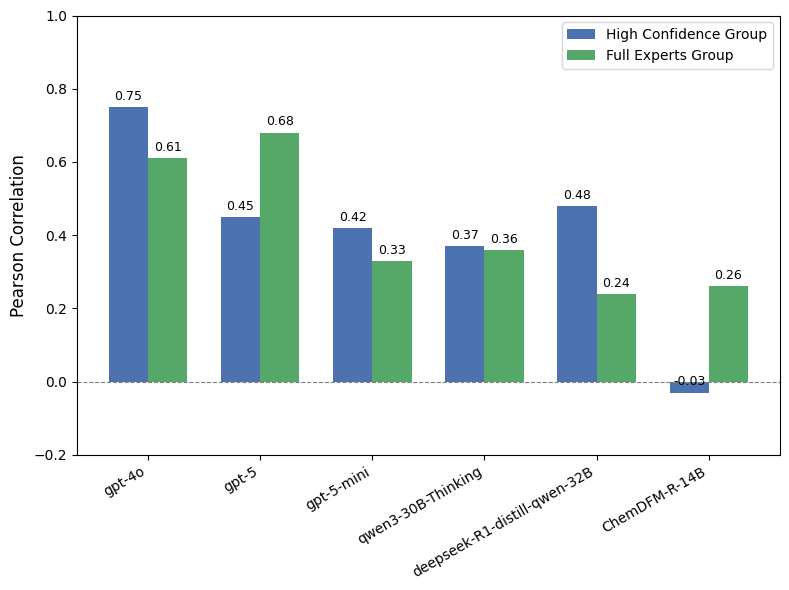

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(high_conf_pearson.keys())
high_conf_values = list(high_conf_pearson.values())
full_values = list(full_pearson.values())

# Bar chart setup
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, high_conf_values, width, label='High Confidence Group', color='#4C72B0')
bars2 = ax.bar(x + width/2, full_values, width, label='Full Experts Group', color='#55A868')

# Labels and formatting
ax.set_ylabel('Pearson Correlation', fontsize=12)
# ax.set_xlabel('Judge Model', fontsize=12)
# ax.set_title('Judge Model Performance Comparison (Pearson Correlation with Expert)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper right')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax.set_ylim(-0.2, 1.0)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
plt.close()

## Judge Model Candidate

2025.12.17

Judge model candidate:
- GPT-4o-Aug
- o4-mini
- Claude Sonnet 4.5
- Gemini 3 Pro
- Llama-3.1-8B-Instruct
- Llama-3.3-70B-Instruct
- Qwen3-4B-Instruct
- Qwen3-4B-Thinking
- Prometheus 2 7B
- JudgeLRM 7B

In [8]:
import sys
sys.path.insert(0, '/workspace/Materials_RL')
from judge_agreement import load_judge_scores_as_df, load_expert_scores
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File mapping for each judge model
judge_files = {
    'GPT-4o-Aug': 'outputs/human_eval/mixed-10test-0117_gpt-4o-2024-08-06_judge_1shot.jsonl',
    'o4-mini': 'outputs/human_eval/mixed-10test-0117_o4-mini_judge_1shot.jsonl',
    'Claude Sonnet 4.5': 'outputs/human_eval/mixed-10test-0117_claude-sonnet-4.5_judge_1shot.jsonl',
    'Gemini 3 Pro': 'outputs/human_eval/mixed-10test-0117_gemini-3-pro-preview_judge_1shot.jsonl',
    'Llama-3.1-8B': 'outputs/human_eval/mixed-10test-0117_Llama-3.1-8B-Instruct_judge_1shot.jsonl',
    'Llama-3.3-70B': 'outputs/human_eval/mixed-10test-0117_Llama-3.3-70B-Instruct_judge_1shot.jsonl',
    'Qwen3-4B-Instruct': 'outputs/human_eval/mixed-10test-0117_Qwen3-4B-Instruct-2507_judge_1shot.jsonl',
    'Qwen3-4B-Thinking': 'outputs/human_eval/mixed-10test-0117_Qwen3-4B-Thinking-2507_judge_1shot.jsonl',
    'Prometheus-7B': 'outputs/human_eval/mixed-10test-0117_prometheus-7b-v2.0_judge_1shot.jsonl',
    'JudgeLRM-7B': 'outputs/human_eval/mixed-10test-0117_JudgeLRM-7B_judge_judgelrm.jsonl',
}

# High confidence evaluators to remove (low confidence ones)
low_conf_evaluators = ['김윤서', '이치훈', '전동원', '홍지훈', '배지수']

# Load expert scores for both groups
expert_csv = '/workspace/Materials_RL/outputs/human_eval/0117-2차평가-예측평가.csv'
label_jsonl = '/workspace/Materials_RL/outputs/human_eval/mixed-10test-0117.jsonl'

df_expert_full = load_expert_scores(expert_csv, label_jsonl=label_jsonl, id_column='Paper ID')
df_expert_high = load_expert_scores(expert_csv, label_jsonl=label_jsonl, id_column='Paper ID', remove_evaluators=low_conf_evaluators)

print(f'Expert Full: {len(df_expert_full)} samples')
print(f'Expert High-conf: {len(df_expert_high)} samples')

Expert Full: 20 samples
Expert High-conf: 20 samples


In [9]:
# Compute agreement scores for all models
results = {'high_conf': {}, 'full': {}}

for model_name, judge_path in judge_files.items():
    full_path = f'/workspace/Materials_RL/{judge_path}'
    df_judge = load_judge_scores_as_df(full_path, combine_id_model=True)
    
    for group_name, df_expert in [('high_conf', df_expert_high), ('full', df_expert_full)]:
        # Find common samples
        common_ids = list(set(df_judge.index) & set(df_expert.index))
        
        if len(common_ids) < 2:
            results[group_name][model_name] = {'pearson': np.nan, 'spearman': np.nan, 'ttest_p': np.nan}
            continue
        
        # Get judge's Overall and expert's Overall Score AVG
        if 'Overall' in df_judge.columns:
            j = df_judge.loc[common_ids, 'Overall'].values
        elif 'Overall Score AVG' in df_judge.columns:
            j = df_judge.loc[common_ids, 'Overall Score AVG'].values
        else:
            results[group_name][model_name] = {'pearson': np.nan, 'spearman': np.nan, 'ttest_p': np.nan}
            continue
            
        e = df_expert.loc[common_ids, 'Overall Score AVG'].values
        
        # Remove NaN pairs
        mask = ~(np.isnan(j) | np.isnan(e))
        j, e = j[mask], e[mask]
        
        if len(j) < 2:
            results[group_name][model_name] = {'pearson': np.nan, 'spearman': np.nan, 'ttest_p': np.nan}
            continue
        
        pearson_r, _ = stats.pearsonr(j, e)
        spearman_r, _ = stats.spearmanr(j, e)
        _, ttest_p = stats.ttest_ind(j, e)
        
        results[group_name][model_name] = {
            'pearson': round(pearson_r, 3),
            'spearman': round(spearman_r, 3),
            'ttest_p': round(ttest_p, 3),
            'n_samples': len(j)
        }

# Display results
print("High-Confidence Group:")
for m, v in results['high_conf'].items():
    print(f"  {m}: Pearson={v['pearson']:.3f}, Spearman={v['spearman']:.3f}, t-test p={v['ttest_p']:.3f}")
print("\nFull Group:")
for m, v in results['full'].items():
    print(f"  {m}: Pearson={v['pearson']:.3f}, Spearman={v['spearman']:.3f}, t-test p={v['ttest_p']:.3f}")

High-Confidence Group:
  GPT-4o-Aug: Pearson=0.754, Spearman=0.684, t-test p=0.007
  o4-mini: Pearson=0.732, Spearman=0.727, t-test p=0.000
  Claude Sonnet 4.5: Pearson=0.354, Spearman=0.292, t-test p=0.000
  Gemini 3 Pro: Pearson=0.733, Spearman=0.684, t-test p=0.000
  Llama-3.1-8B: Pearson=0.383, Spearman=0.225, t-test p=0.955
  Llama-3.3-70B: Pearson=0.234, Spearman=0.272, t-test p=0.231
  Qwen3-4B-Instruct: Pearson=0.547, Spearman=0.515, t-test p=0.000
  Qwen3-4B-Thinking: Pearson=0.619, Spearman=0.521, t-test p=0.000
  Prometheus-7B: Pearson=0.395, Spearman=0.264, t-test p=0.981
  JudgeLRM-7B: Pearson=0.638, Spearman=0.617, t-test p=0.223

Full Group:
  GPT-4o-Aug: Pearson=0.610, Spearman=0.539, t-test p=0.001
  o4-mini: Pearson=0.686, Spearman=0.665, t-test p=0.327
  Claude Sonnet 4.5: Pearson=0.597, Spearman=0.527, t-test p=0.049
  Gemini 3 Pro: Pearson=0.736, Spearman=0.688, t-test p=0.069
  Llama-3.1-8B: Pearson=0.439, Spearman=0.326, t-test p=0.000
  Llama-3.3-70B: Pearson=0.

In [10]:
# Prepare data for plotting
models = list(judge_files.keys())
high_conf_pearson = [results['high_conf'][m]['pearson'] for m in models]
full_pearson = [results['full'][m]['pearson'] for m in models]
high_conf_spearman = [results['high_conf'][m]['spearman'] for m in models]
full_spearman = [results['full'][m]['spearman'] for m in models]
high_conf_ttest = [results['high_conf'][m]['ttest_p'] for m in models]
full_ttest = [results['full'][m]['ttest_p'] for m in models]

# Model categories
API_MODELS = ['GPT-4o-Aug', 'o4-mini', 'Claude Sonnet 4.5', 'Gemini 3 Pro']
OPENWEIGHT_MODELS = ['Llama-3.1-8B', 'Llama-3.3-70B', 'Qwen3-4B-Instruct', 'Qwen3-4B-Thinking']
JUDGE_MODELS = ['Prometheus-7B', 'JudgeLRM-7B']

# Color palettes for each category (High-conf, Full)
CATEGORY_COLORS = {
    'API': ('#2E86AB', '#A3D5FF'),           # Blue shades
    'Openweight': ('#28A745', '#90EE90'),    # Green shades  
    'Judge': ('#E94F37', '#FFB347'),         # Red/Orange shades
}

def get_model_colors(models):
    """Get colors for each model based on category."""
    high_colors = []
    full_colors = []
    for m in models:
        if m in API_MODELS:
            high_colors.append(CATEGORY_COLORS['API'][0])
            full_colors.append(CATEGORY_COLORS['API'][1])
        elif m in OPENWEIGHT_MODELS:
            high_colors.append(CATEGORY_COLORS['Openweight'][0])
            full_colors.append(CATEGORY_COLORS['Openweight'][1])
        else:
            high_colors.append(CATEGORY_COLORS['Judge'][0])
            full_colors.append(CATEGORY_COLORS['Judge'][1])
    return high_colors, full_colors

def plot_metric_bar_chart(high_values, full_values, models, ylabel, title, ylim=None, show_threshold=None):
    """Plot grouped bar chart for a metric with category-based colors."""
    x = np.arange(len(models))
    width = 0.35
    
    high_colors, full_colors = get_model_colors(models)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars with individual colors
    for i, (hv, fv, hc, fc) in enumerate(zip(high_values, full_values, high_colors, full_colors)):
        ax.bar(x[i] - width/2, hv, width, color=hc, edgecolor='black', linewidth=0.5)
        ax.bar(x[i] + width/2, fv, width, color=fc, edgecolor='black', linewidth=0.5)
    
    # Create legend patches
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=CATEGORY_COLORS['API'][0], edgecolor='black', label='API (High-Conf)'),
        Patch(facecolor=CATEGORY_COLORS['API'][1], edgecolor='black', label='API (Full)'),
        Patch(facecolor=CATEGORY_COLORS['Openweight'][0], edgecolor='black', label='Open-weight (High-Conf)'),
        Patch(facecolor=CATEGORY_COLORS['Openweight'][1], edgecolor='black', label='Open-weight (Full)'),
        Patch(facecolor=CATEGORY_COLORS['Judge'][0], edgecolor='black', label='Specialized Judge (High-Conf)'),
        Patch(facecolor=CATEGORY_COLORS['Judge'][1], edgecolor='black', label='Specialized Judge (Full)'),
    ]
    
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, ncol=2)
    
    if ylim:
        ax.set_ylim(ylim)
    
    # Add reference lines
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    if show_threshold is not None:
        ax.axhline(y=show_threshold, color='red', linestyle=':', linewidth=1.2)
    
    # Add value labels on bars
    for i, (hv, fv) in enumerate(zip(high_values, full_values)):
        if not np.isnan(hv):
            ax.annotate(f'{hv:.2f}', xy=(x[i] - width/2, hv),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        if not np.isnan(fv):
            ax.annotate(f'{fv:.2f}', xy=(x[i] + width/2, fv),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    return fig, ax

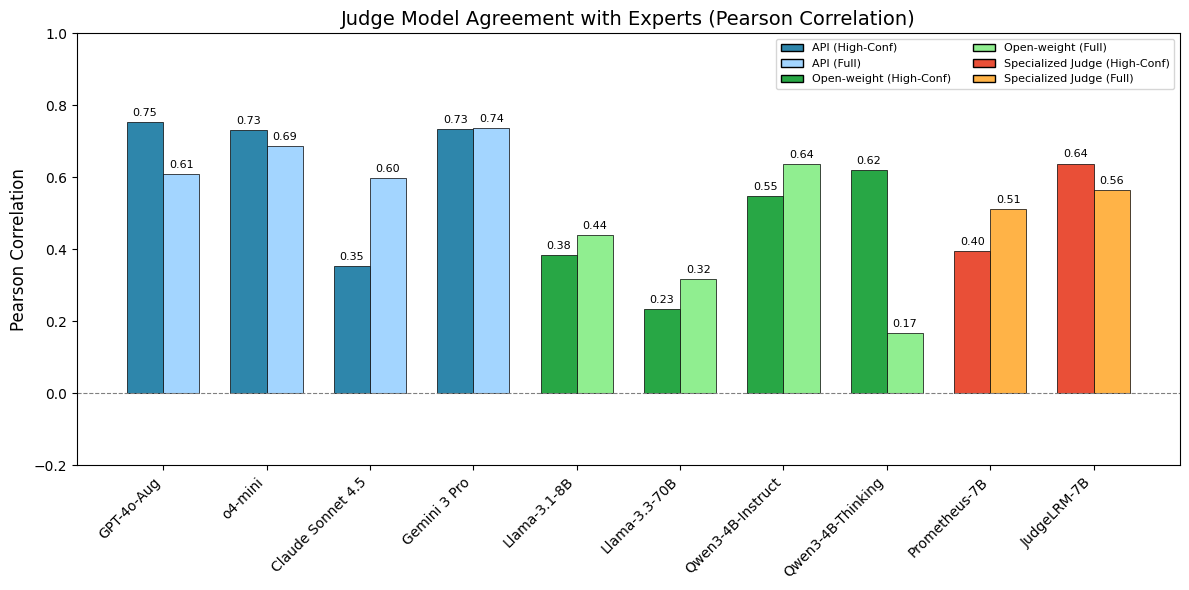

In [11]:
# 1. Pearson Correlation Bar Chart
plot_metric_bar_chart(
    high_conf_pearson, full_pearson, models,
    ylabel='Pearson Correlation',
    title='Judge Model Agreement with Experts (Pearson Correlation)',
    ylim=(-0.2, 1.0)
)
plt.savefig('/workspace/Materials_RL/analysis/pearson_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

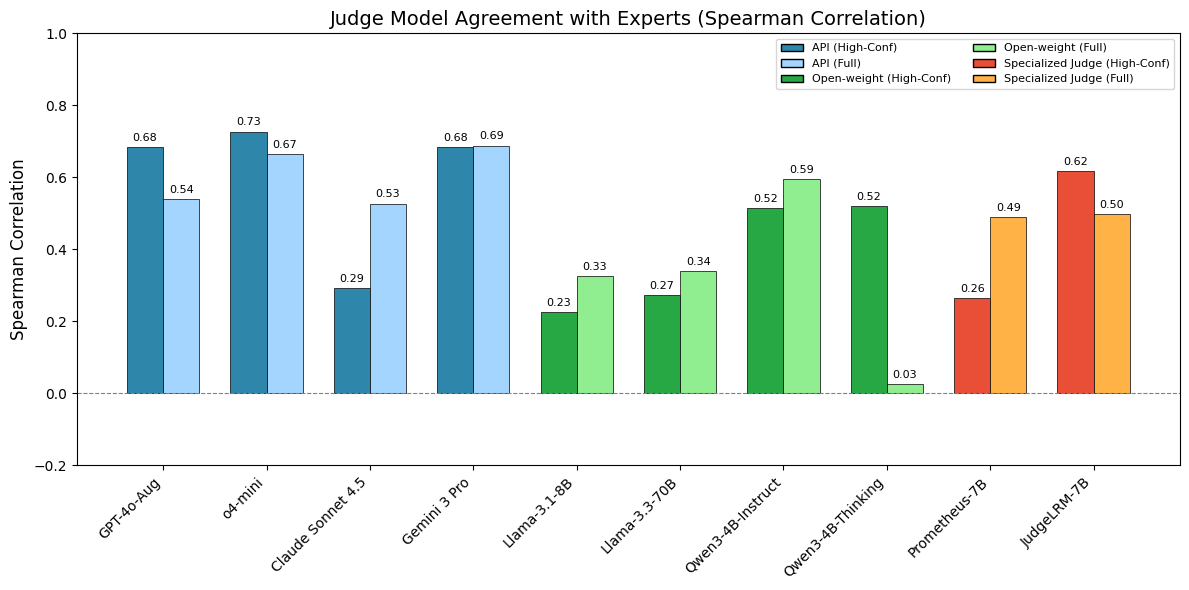

In [12]:
# 2. Spearman Correlation Bar Chart
plot_metric_bar_chart(
    high_conf_spearman, full_spearman, models,
    ylabel='Spearman Correlation',
    title='Judge Model Agreement with Experts (Spearman Correlation)',
    ylim=(-0.2, 1.0)
)
plt.savefig('/workspace/Materials_RL/analysis/spearman_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

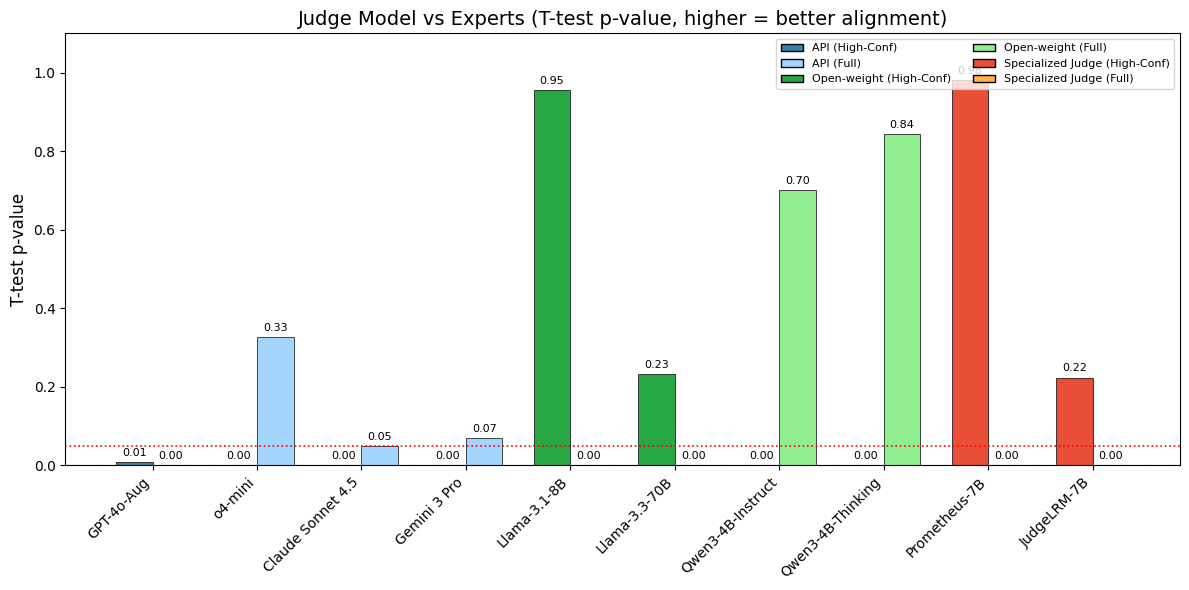

In [13]:
# 3. T-test p-value Bar Chart
# Note: Higher p-value means less significant difference (better alignment with experts)
plot_metric_bar_chart(
    high_conf_ttest, full_ttest, models,
    ylabel='T-test p-value',
    title='Judge Model vs Experts (T-test p-value, higher = better alignment)',
    ylim=(0, 1.1),
    show_threshold=0.05
)
plt.savefig('/workspace/Materials_RL/analysis/ttest_pvalue.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Summary table
import pandas as pd

summary_data = []
for m in models:
    summary_data.append({
        'Model': m,
        'Pearson (High)': results['high_conf'][m]['pearson'],
        'Pearson (Full)': results['full'][m]['pearson'],
        'Spearman (High)': results['high_conf'][m]['spearman'],
        'Spearman (Full)': results['full'][m]['spearman'],
        'T-test p (High)': results['high_conf'][m]['ttest_p'],
        'T-test p (Full)': results['full'][m]['ttest_p'],
    })

df_summary = pd.DataFrame(summary_data)
df_summary.set_index('Model', inplace=True)
df_summary

,Pearson (High),Pearson (Full),Spearman (High),Spearman (Full),T-test p (High),T-test p (Full)
Model,,,,,,
GPT-4o-Aug,0.754,0.610,0.684,0.539,0.007,0.001
o4-mini,0.732,0.686,0.727,0.665,0.000,0.327
Claude Sonnet 4.5,0.354,0.597,0.292,0.527,0.000,0.049
Gemini 3 Pro,0.733,0.736,0.684,0.688,0.000,0.069
Llama-3.1-8B,0.383,0.439,0.225,0.326,0.955,0.000
Llama-3.3-70B,0.234,0.317,0.272,0.339,0.231,0.000
Qwen3-4B-Instruct,0.547,0.637,0.515,0.595,0.000,0.701
Qwen3-4B-Thinking,0.619,0.168,0.521,0.025,0.000,0.844
Prometheus-7B,0.395,0.512,0.264,0.490,0.981,0.000
